# 📊 GitHub Events - Data Exploration

**Purpose:** Exploratory Data Analysis (EDA) del pipeline de eventos de GitHub

**Contents:**
1. Load data from pipeline
2. Data quality checks
3. Distribution analysis
4. Temporal patterns
5. Top repos and contributors

In [1]:
# Setup & Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Imports successful")


✓ Imports successful


## Load Data

In [2]:
def load_latest_metrics():
    """Carga las métricas más recientes del pipeline."""
    metrics_file = Path('../data/metrics/latest_metrics.json')
    
    if not metrics_file.exists():
        print("⚠️  No metrics found. Run the pipeline first: python src/main.py")
        return None
    
    with open(metrics_file) as f:
        metrics = json.load(f)
    
    print(f"✓ Loaded metrics calculated at: {metrics['summary']['calculation_timestamp']}")
    print(f"  Total events: {metrics['summary']['total_events']:,}")
    
    return metrics

def load_curated_events():
    """Carga eventos procesados (Silver layer)."""
    curated_dir = Path('../data/curated')
    
    if not curated_dir.exists() or not list(curated_dir.glob('*.json')):
        print("⚠️  No curated events found")
        return None
    
    latest_file = max(curated_dir.glob('*.json'), key=lambda x: x.stat().st_mtime)
    
    with open(latest_file) as f:
        events = json.load(f)
    
    df = pd.DataFrame(events)
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['event_date'] = pd.to_datetime(df['event_date'])
    
    print(f"✓ Loaded {len(df):,} curated events from {latest_file.name}")
    print(f"  Date range: {df['created_at'].min()} to {df['created_at'].max()}")
    
    return df

metrics = load_latest_metrics()
events_df = load_curated_events()


✓ Loaded metrics calculated at: 2026-01-12T22:13:50.437219
  Total events: 14
✓ Loaded 14 curated events from events_curated_20260112_221350.json
  Date range: 2026-01-12 19:59:06+00:00 to 2026-01-12 22:04:05+00:00



## Data Quality Overview

In [3]:
if events_df is not None:
    print("DATASET INFO")
    print("=" * 60)
    print(f"Shape: {events_df.shape[0]:,} rows × {events_df.shape[1]} columns")
    print(f"\nMemory usage: {events_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nDate range: {(events_df['created_at'].max() - events_df['created_at'].min()).days} days")
    
    print("\n DATA QUALITY CHECKS")
    print("=" * 60)
    
    # Missing values
    missing = events_df.isnull().sum()
    if missing.sum() > 0:
        print("⚠️  Missing values:")
        print(missing[missing > 0])
    else:
        print("✓ No missing values")
    
    # Duplicates
    duplicates = events_df.duplicated(subset=['event_id']).sum()
    print(f"\n{'⚠️ ' if duplicates > 0 else '✓ '}Duplicates: {duplicates}")
    
    # Data types
    print("\n Column Data Types:")
    print(events_df.dtypes)


📋 DATASET INFO
Shape: 14 rows × 26 columns

Memory usage: 0.02 MB

Date range: 0 days

🔍 DATA QUALITY CHECKS
⚠️  Missing values:
pr_action              3
pr_state              14
pr_merged              3
pr_additions           3
pr_deletions           3
push_size             13
push_ref              13
push_commits_count    13
dtype: int64

✓ Duplicates: 0

📊 Column Data Types:
event_id                                  object
event_type                                object
created_at                   datetime64[ns, UTC]
repo_id                                    int64
repo_name                                 object
repo_url                                  object
actor_id                                   int64
actor_login                               object
payload                                   object
_ingestion_timestamp                      object
_transformation_timestamp                 object
_source                                   object
event_date                     

In [9]:
if events_df is not None:
    print(" Sample Data (first 5 rows):\n")
    display(events_df.head())
    
    print("\n Descriptive Statistics:\n")
    display(events_df.describe())


👀 Sample Data (first 5 rows):



,event_id,event_type,created_at,repo_id,repo_name,repo_url,actor_id,actor_login,payload,_ingestion_timestamp,_transformation_timestamp,_source,event_date,event_hour,_content_hash,activity_category,is_active_contribution,time_of_day,pr_action,pr_state,pr_merged,pr_additions,pr_deletions,push_size,push_ref,push_commits_count
0,5762206519,ForkEvent,2026-01-12 22:04:05+00:00,17165658,apache/spark,https://api.github.com/repos/apache/spark,25234451,K5qu4r3d,"{'action': 'forked', 'forkee': {'id': 11330989...",2026-01-12T22:15:28.460744,2026-01-12T22:13:50.434787,github_api,2026-01-12,22,b649421315c79d25099d528c57648e75,other,False,evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5761976351,PullRequestEvent,2026-01-12 21:51:30+00:00,17165658,apache/spark,https://api.github.com/repos/apache/spark,99207096,dtenedor,"{'action': 'closed', 'number': 53548, 'pull_re...",2026-01-12T22:15:28.460747,2026-01-12T22:13:50.435189,github_api,2026-01-12,21,c73dd486322a1ddfa67dd7848d92dd67,code_review,True,evening,closed,NaN,False,0.0,0.0,NaN,NaN,NaN
2,7406966586,PushEvent,2026-01-12 21:52:28+00:00,17165658,apache/spark,https://api.github.com/repos/apache/spark,99207096,dtenedor,"{'repository_id': 17165658, 'push_id': 2970205...",2026-01-12T22:15:28.460748,2026-01-12T22:13:50.435274,github_api,2026-01-12,21,42730ac3b0a6d1975b33eaa4dedd416d,code_change,True,evening,NaN,NaN,NaN,NaN,NaN,0.0,refs/heads/master,0.0
3,5761512113,PullRequestEvent,2026-01-12 21:27:01+00:00,17165658,apache/spark,https://api.github.com/repos/apache/spark,41898282,github-actions[bot],"{'action': 'labeled', 'number': 53774, 'pull_r...",2026-01-12T22:15:28.460757,2026-01-12T22:13:50.435308,github_api,2026-01-12,21,b92aac07278c66a67bf9bff55819c1ed,code_review,True,evening,labeled,NaN,False,0.0,0.0,NaN,NaN,NaN
4,5761512112,PullRequestEvent,2026-01-12 21:27:01+00:00,17165658,apache/spark,https://api.github.com/repos/apache/spark,41898282,github-actions[bot],"{'action': 'labeled', 'number': 53774, 'pull_r...",2026-01-12T22:15:28.460759,2026-01-12T22:13:50.435354,github_api,2026-01-12,21,1568763e808d48511badb942bda8dcfe,code_review,True,evening,labeled,NaN,False,0.0,0.0,NaN,NaN,NaN



📈 Descriptive Statistics:



,repo_id,actor_id,event_date,event_hour,pr_state,pr_additions,pr_deletions,push_size,push_commits_count
count,14.0,1.400000e+01,14,14.000000,0.0,11.0,11.0,1.0,1.0
mean,17165658.0,4.319247e+07,2026-01-12 00:00:00,20.357143,NaN,0.0,0.0,0.0,0.0
min,17165658.0,5.989300e+04,2026-01-12 00:00:00,19.000000,NaN,0.0,0.0,0.0,0.0
25%,17165658.0,2.940041e+07,2026-01-12 00:00:00,19.000000,NaN,0.0,0.0,0.0,0.0
50%,17165658.0,4.189828e+07,2026-01-12 00:00:00,21.000000,NaN,0.0,0.0,0.0,0.0
75%,17165658.0,4.189828e+07,2026-01-12 00:00:00,21.000000,NaN,0.0,0.0,0.0,0.0
max,17165658.0,9.920710e+07,2026-01-12 00:00:00,22.000000,NaN,0.0,0.0,0.0,0.0
std,0.0,2.857114e+07,NaN,1.081818,NaN,0.0,0.0,NaN,NaN


##  Event Type Distribution


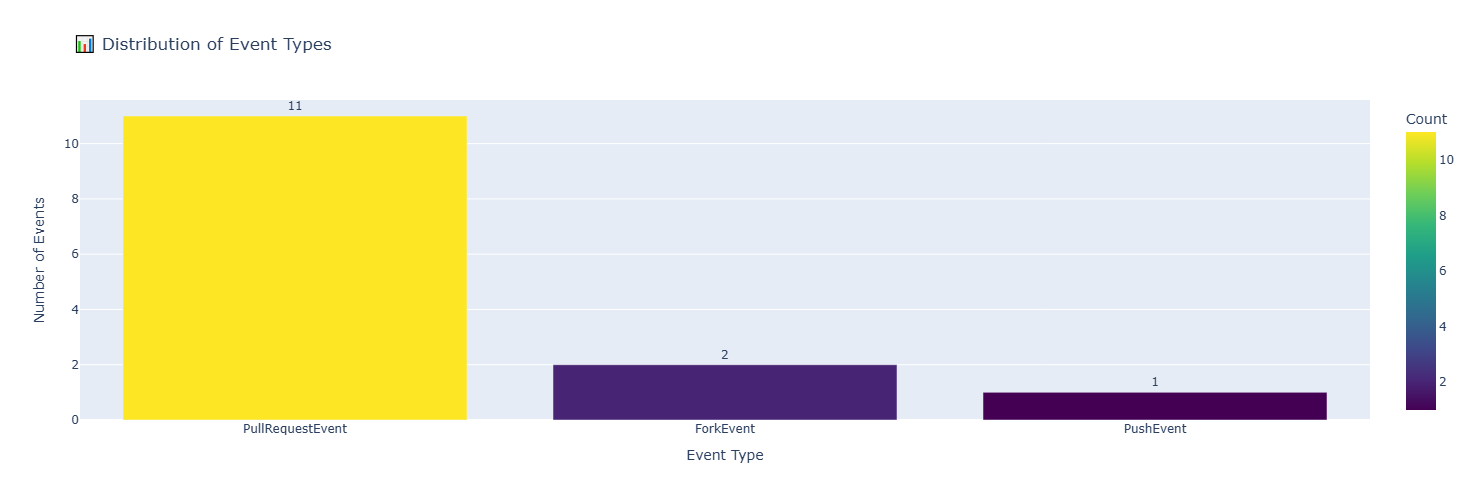

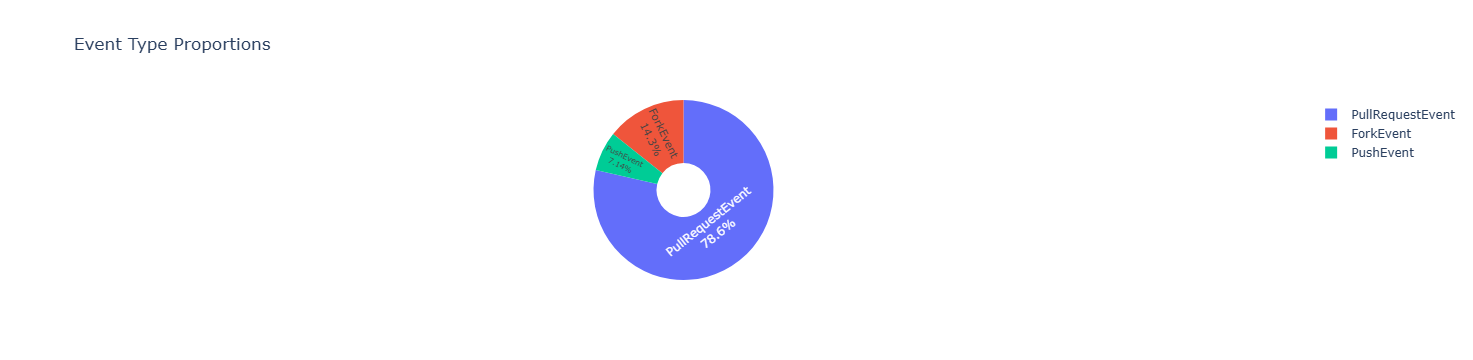

In [10]:
if metrics and events_df is not None:
    # Prepare data
    event_types = pd.DataFrame([
        {'Event Type': k, 'Count': v} 
        for k, v in metrics['event_types'].items()
    ]).sort_values('Count', ascending=False)
    
    # Bar chart
    fig = px.bar(
        event_types, 
        x='Event Type', 
        y='Count',
        title='📊 Distribution of Event Types',
        color='Count',
        color_continuous_scale='Viridis',
        text='Count'
    )
    
    fig.update_traces(texttemplate='%{text:,}', textposition='outside')
    fig.update_layout(
        xaxis_title='Event Type',
        yaxis_title='Number of Events',
        showlegend=False,
        height=500
    )
    
    fig.show()
    
    # Pie chart
    fig_pie = px.pie(
        event_types, 
        values='Count', 
        names='Event Type',
        title='Event Type Proportions',
        hole=0.3
    )
    
    fig_pie.update_traces(textposition='inside', textinfo='percent+label')
    fig_pie.show()


# Temporal Patterns

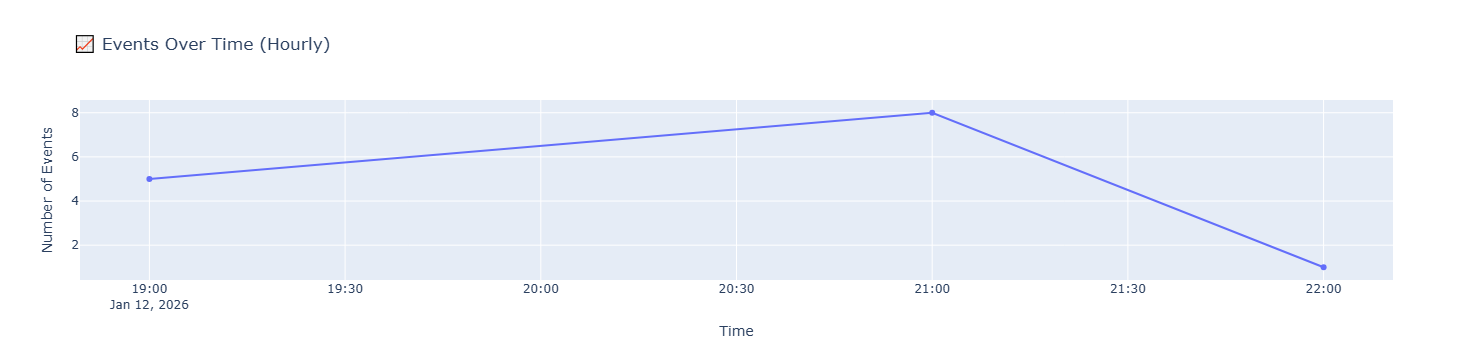

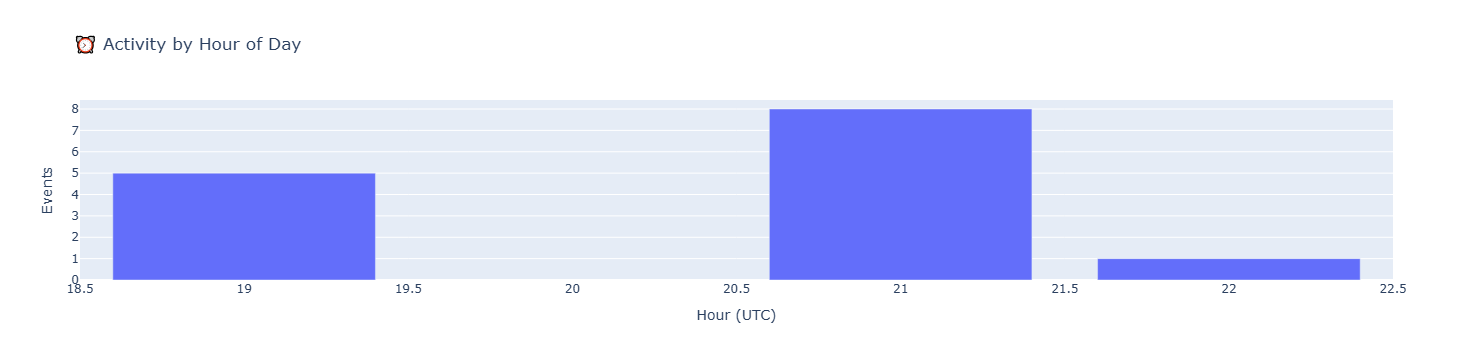

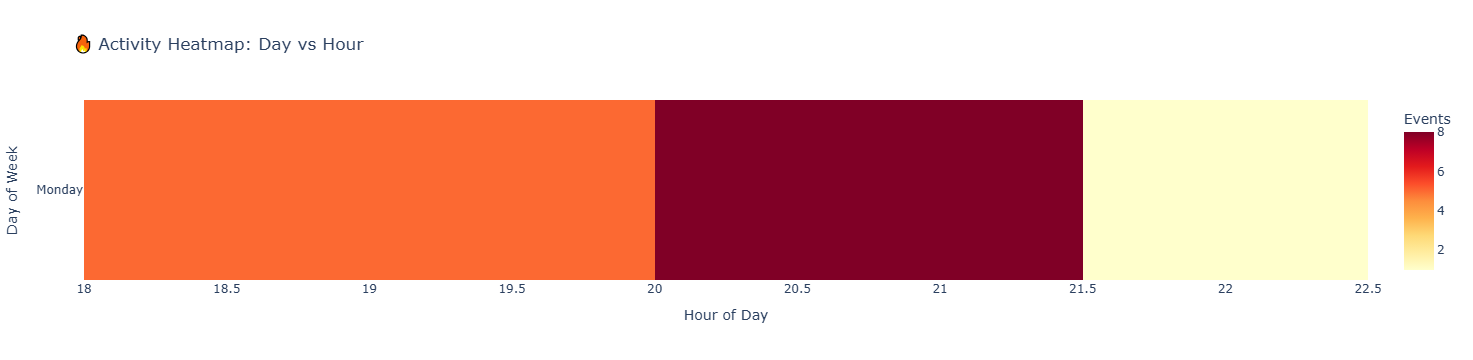

In [16]:
if events_df is not None:
    # Events over time (hourly)
    hourly = events_df.groupby(events_df['created_at'].dt.floor('H')).size().reset_index()
    hourly.columns = ['timestamp', 'events']
    fig = px.line(hourly, x='timestamp', y='events', title=' Events Over Time (Hourly)', markers=True)
    fig.update_layout(xaxis_title='Time', yaxis_title='Number of Events', hovermode='x unified')
    fig.show()

    # Events by hour of day
    hourly_dist = events_df.groupby('event_hour').size().reset_index()
    hourly_dist.columns = ['hour', 'count']
    fig = px.bar(hourly_dist, x='hour', y='count', title=' Activity by Hour of Day', labels={'hour': 'Hour (UTC)', 'count': 'Events'})
    fig.update_yaxes(dtick=1)
    fig.show()

    # Heatmap: Day vs Hour
    events_df['day_of_week'] = events_df['created_at'].dt.day_name()
    heatmap_data = events_df.groupby(['day_of_week', 'event_hour']).size().reset_index()
    heatmap_data.columns = ['day', 'hour', 'count']
    heatmap_pivot = heatmap_data.pivot(index='day', columns='hour', values='count').fillna(0)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_pivot = heatmap_pivot.reindex([d for d in day_order if d in heatmap_pivot.index])
    fig = px.imshow(heatmap_pivot, labels=dict(x='Hour of Day', y='Day of Week', color='Events'), title='🔥 Activity Heatmap: Day vs Hour', color_continuous_scale='YlOrRd')
    fig.show()

# Repo analysis

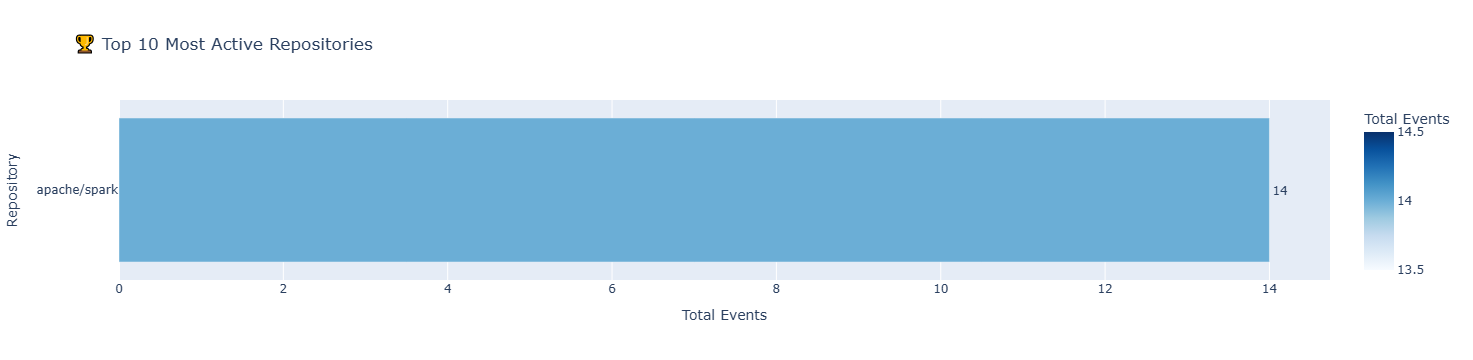


📊 Repository Statistics:



,Repository,Total Events,Contributors,Active Contributions,Engagement Rate
0,apache/spark,14,6,12,85.7%


In [12]:
if metrics:
    top_repos = pd.DataFrame(metrics['rankings']['top_repos'])
    fig = px.bar(
        top_repos.head(10),
        x='total_events',
        y='repo',
        orientation='h',
        title='🏆 Top 10 Most Active Repositories',
        labels={'total_events': 'Total Events', 'repo': 'Repository'},
        text='total_events',
        color='total_events',
        color_continuous_scale='Blues'
    )
    fig.update_traces(texttemplate='%{text:,}', textposition='outside')
    fig.update_layout(yaxis={'categoryorder':'total ascending'}, showlegend=False)
    fig.show()

    print("\n📊 Repository Statistics:\n")
    repo_stats = pd.DataFrame([
        {
            'Repository': repo,
            'Total Events': stats['total_events'],
            'Contributors': stats['unique_contributors'],
            'Active Contributions': stats['active_contributions'],
            'Engagement Rate': f"{stats['active_contributions']/stats['total_events']*100:.1f}%"
        }
        for repo, stats in list(metrics['repos'].items())[:10]
    ]).sort_values('Total Events', ascending=False)
    display(repo_stats)

# Contributor analysis

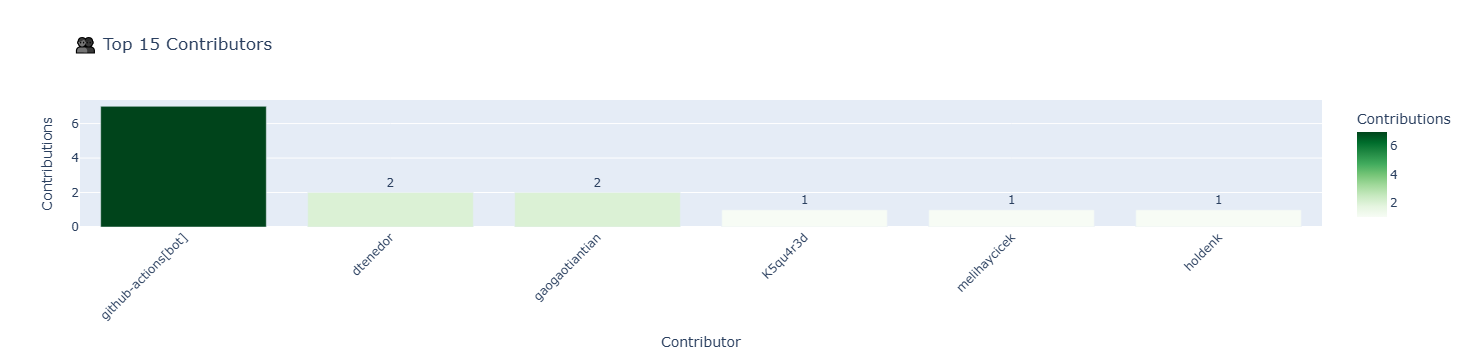


👥 Total unique contributors: 6


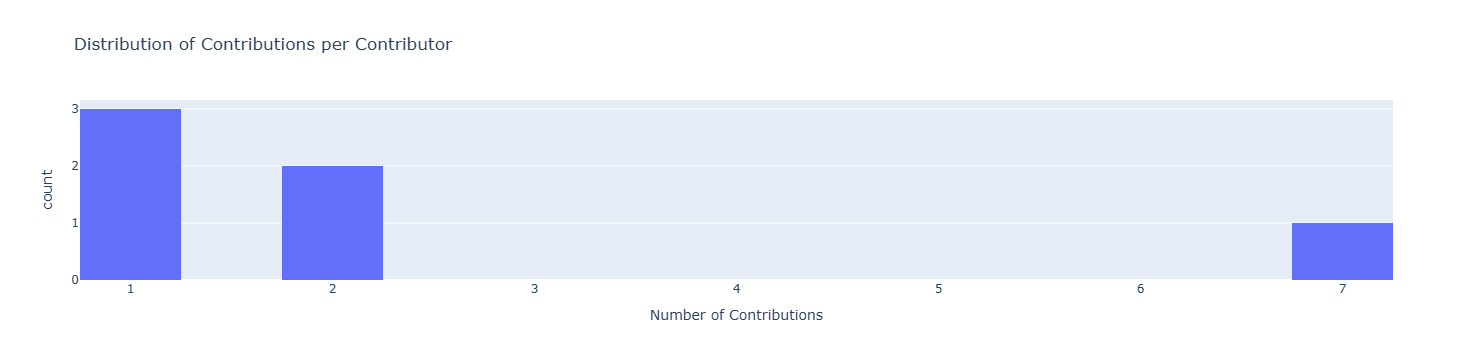

In [13]:
if metrics:
    top_contributors = pd.DataFrame(metrics['rankings']['top_contributors'])
    fig = px.bar(
        top_contributors.head(15),
        x='contributor',
        y='total_contributions',
        title='👥 Top 15 Contributors',
        labels={'total_contributions': 'Contributions', 'contributor': 'Contributor'},
        text='total_contributions',
        color='total_contributions',
        color_continuous_scale='Greens'
    )
    fig.update_traces(texttemplate='%{text:,}', textposition='outside')
    fig.update_layout(showlegend=False, xaxis_tickangle=-45)
    fig.show()

    print(f"\n👥 Total unique contributors: {len(metrics['contributors']):,}")
    contrib_counts = [stats['total_contributions'] for stats in metrics['contributors'].values()]
    fig = px.histogram(x=contrib_counts, title='Distribution of Contributions per Contributor', labels={'x': 'Number of Contributions', 'y': 'Number of Contributors'}, nbins=20)
    fig.show()

# Activity categories

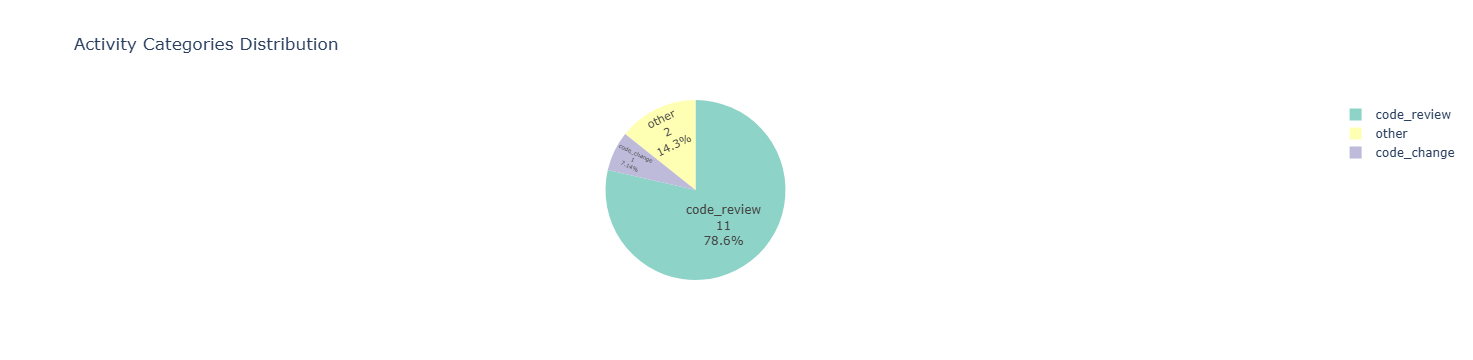

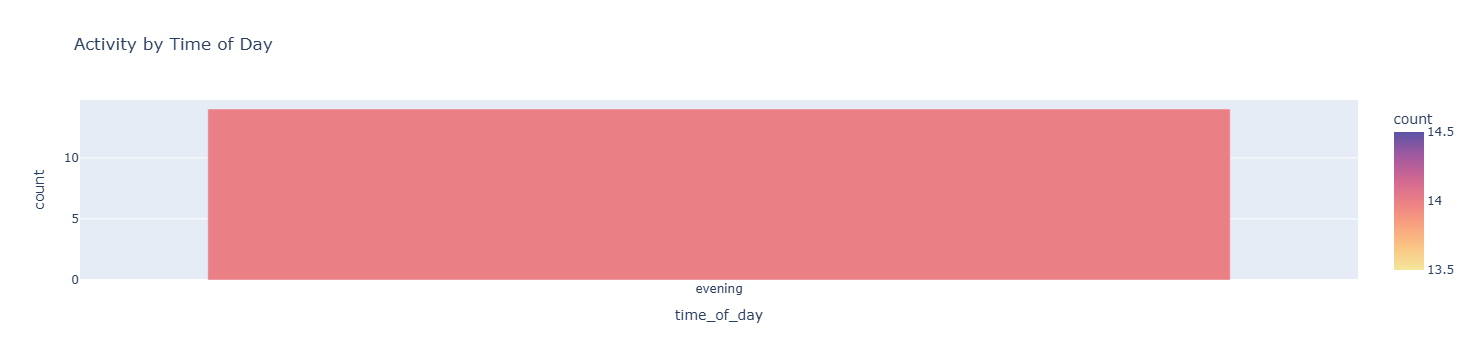

In [14]:
if events_df is not None and 'activity_category' in events_df.columns:
    activity_dist = events_df['activity_category'].value_counts().reset_index()
    activity_dist.columns = ['category', 'count']
    fig = px.pie(activity_dist, values='count', names='category', title='Activity Categories Distribution', color_discrete_sequence=px.colors.qualitative.Set3)
    fig.update_traces(textposition='inside', textinfo='percent+label+value')
    fig.show()

    if 'time_of_day' in events_df.columns:
        time_dist = events_df['time_of_day'].value_counts().reset_index()
        time_dist.columns = ['time_of_day', 'count']
        time_order = ['morning', 'afternoon', 'evening', 'night']
        time_dist['time_of_day'] = pd.Categorical(time_dist['time_of_day'], categories=time_order, ordered=True)
        time_dist = time_dist.sort_values('time_of_day')
        fig = px.bar(time_dist, x='time_of_day', y='count', title='Activity by Time of Day', color='count', color_continuous_scale='Sunset')
        fig.show()

# Summary and insights

In [15]:
if metrics and events_df is not None:
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    total_events = metrics['summary']['total_events']
    print(f"\n1️⃣  VOLUME")
    print(f"   • Total events processed: {total_events:,}")
    print(f"   • Unique repositories: {len(metrics['repos'])}")
    print(f"   • Unique contributors: {len(metrics['contributors'])}")
    top_event_type = max(metrics['event_types'].items(), key=lambda x: x[1])
    print(f"\n2️⃣  TOP EVENT TYPE")
    print(f"   • {top_event_type[0]}: {top_event_type[1]:,} events ({top_event_type[1]/total_events*100:.1f}%)")
    top_repo = metrics['rankings']['top_repos'][0]
    print(f"\n3️⃣  MOST ACTIVE REPOSITORY")
    print(f"   • {top_repo['repo']}")
    print(f"   • {top_repo['total_events']:,} events")
    print(f"   • {top_repo['unique_contributors']} contributors")
    top_contributor = metrics['rankings']['top_contributors'][0]
    print(f"\n4️⃣  MOST ACTIVE CONTRIBUTOR")
    print(f"   • {top_contributor['contributor']}")
    print(f"   • {top_contributor['total_contributions']} contributions")
    print(f"   • Across {top_contributor['repos_count']} repositories")
    peak_hour = events_df['event_hour'].mode()[0]
    print(f"\n5️⃣  TEMPORAL PATTERNS")
    print(f"   • Peak activity hour: {peak_hour:02d}:00 UTC")
    if 'time_of_day' in events_df.columns:
        peak_time = events_df['time_of_day'].mode()[0]
        print(f"   • Most active period: {peak_time}")
    print("\n" + "="*70)


📊 KEY INSIGHTS

1️⃣  VOLUME
   • Total events processed: 14
   • Unique repositories: 1
   • Unique contributors: 6

2️⃣  TOP EVENT TYPE
   • PullRequestEvent: 11 events (78.6%)

3️⃣  MOST ACTIVE REPOSITORY
   • apache/spark
   • 14 events
   • 6 contributors

4️⃣  MOST ACTIVE CONTRIBUTOR
   • github-actions[bot]
   • 7 contributions
   • Across 1 repositories

5️⃣  TEMPORAL PATTERNS
   • Peak activity hour: 21:00 UTC
   • Most active period: evening

